### The Village

This is the villge generator I will take you through the different steps we use to build out the village. This village is trained on the PodCast Critical role and each one of the players on this podcast is represented here

In [1]:
! pip -q install transformers

In [2]:
!pip -q  install scipy

In [3]:
from google.colab import drive
import os
import pandas as pd
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import itertools
import cv2 as cv
import math
from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


In [4]:
# Mount the drive for google collage 
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/Colab Notebooks")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
# Load in the different models
data_val = pd.read_csv('reponse.csv')
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small')
modeltrav = AutoModelWithLMHead.from_pretrained('TRAVIS')
modelsam = AutoModelWithLMHead.from_pretrained('SAM')
modeltal = AutoModelWithLMHead.from_pretrained('TALIESIN')
modelmatt = AutoModelWithLMHead.from_pretrained('MATT')
modelliam = AutoModelWithLMHead.from_pretrained('LIAM/checkpoint-50000')
modelmarisha = AutoModelWithLMHead.from_pretrained('MARISHA')
modellaura=AutoModelWithLMHead.from_pretrained('LAURA')
modelash=AutoModelWithLMHead.from_pretrained('ASHLEY/checkpoint-20000')

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


This first section is for either user prompts or randomly generate prompt. This takes you through the basic dialog

In [8]:

def speak(dialog,tokenizer,model,name,chat_history_ids=None):
   new_user_input_ids = tokenizer.encode(dialog[-1] + tokenizer.eos_token, return_tensors='pt')
   #print(new_user_input_ids)
   bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if len(dialog) > 1 else new_user_input_ids #bot1
   chat_history_ids = model.generate(
        bot_input_ids, max_length=500,
        pad_token_id=tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=100, 
        top_p=0.5,
        temperature = 0.8
    )
   #print(chat_history_ids)
   words=(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True))
   print(f'{name}:{words}')
   dialog.append(words)
   return dialog,chat_history_ids

In [9]:
dialog=[]
ran=data_val.iloc[random.randint(1, len(data_val)-1),4]
#ran=input("user:")
dialog.append(ran)
print('Prompt',ran)
model_dict={'TRAVIS':modeltrav,'SAM':modelsam,'TALISON':modeltal,'MATT':modelmatt,'MARISHA':modelmarisha,'LIAM':modelliam,'LAURA':modellaura,'ASHLEY':modelash}
name=['TRAVIS','SAM','TALISON','MATT','MARISHA','LIAM','LAURA','ASHLEY']
first=random.randint(0, len(name)-1)
dialog,hist=speak(dialog,tokenizer,model_dict[name[first]],name[first])
prev=9999
for i in range(10):
  while True:
    speaker=random.randint(0, len(name)-1)
    if(speaker!=prev):
      break
  dialog,hist=speak(dialog,tokenizer,model_dict[name[speaker]],name[speaker],hist)
  prev=speaker
  #print(dialog)
  #a=len(hist[0])
  #c=round(c/1.8) 
  #print(hist.shape[1])
  c=np.where((hist[0].flatten().numpy())==50256)[0][1]
  c+=1
  hist=hist[:,c:]
  #b=len(hist[0])
  #print('DIFF',a-b)
    




Prompt  Okay, okay! I'm dropping Seeming.
TRAVIS: You drop Seeming, you drop Seemed.
LIAM: Okay, I'm going to go ahead and use my bonus action to cast Seeming on the ground.
MARISHA: Oh, okay.
LAURA: I'm just going to walk over to the ground and say: Hey, buddy.
MARISHA: Hey, pal.
TALISON: Oh, hey, buddy, hey.
LIAM: I'm going to go to the library.
LAURA: Okay.
TALISON: I'm gonna go to sleep.
MATT: Okay. You guys all head to the outside of the castle.
LIAM: We're going to go to the castle?


Now we take the class and stick it in an object oriented setting

In [12]:
class Townperson:
  def __init__(self, dialog, model,tokenizer,name,x,y,color,speed):
    self.name = name
    self.tokenizer=tokenizer
    self.dialog=dialog
    self.spoken=[]
    self.model=model
    self.x=x
    self.y=y
    self.color=color
    self.speed=speed
    self.chat_history_ids=chat_history_ids = self.model.generate(
        self.tokenizer.encode(self.dialog[-1] + self.tokenizer.eos_token, return_tensors='pt'), max_length=500,
        pad_token_id=self.tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=100, 
        top_p=0.5,
        temperature = 0.8
    )
  def listen(self,words,history):
    if(history.shape[1]>50):
     # c=history.shape[1]
      #c=round(c/2.5)
      c=np.where((history[0].flatten().numpy())==50256)[0][1]
      c+=1
      history=history[:,c:]
    self.dialog.append(words) #what has been spoken previously
    self.chat_history_ids=history #the tokenizers interpretation of what has been spoken


  def speak(self):
   new_user_input_ids = self.tokenizer.encode(self.dialog[-1] + self.tokenizer.eos_token, return_tensors='pt')
   bot_input_ids = torch.cat([self.chat_history_ids, new_user_input_ids], dim=-1) if len(self.dialog) > 1 else new_user_input_ids #bot1
   chat_history_ids = self.model.generate(
        bot_input_ids, max_length=500,
        pad_token_id=self.tokenizer.eos_token_id,  
        no_repeat_ngram_size=3,       
        do_sample=True, 
        top_k=100, 
        top_p=0.5,
        temperature = 0.8
    )
   words=(self.tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True))
   print(f'{self.name}:{words}')
   self.spoken.append(words)
   self.dialog.append(words)
  # c=chat_history_ids.shape[1]
   #c=round(c/2.5)
   c=np.where((chat_history_ids[0].flatten().numpy())==50256)[0][1]
   c+=1
   self.chat_history_ids=chat_history_ids[:,c:]
   return words, chat_history_ids[:,c:]

  def move(self):
     """The person moves if in the area or stands still if not """
     x=self.x+random.randint(-10, 10)/10*self.speed
     y=self.y+random.randint(-10, 10)/10*self.speed
     if(x>0 and x<700 and y>0 and y <490):
       self.x=x
       self.y=y
def dual_convo(tup):
  conversation=[]
  length=random.randint(3,10)
  for i in range(length):
    words,hist=tup[0].speak()
    conversation.append((tup[0].name,words))
    tup[1].listen(words,hist)
    words,hist=tup[1].speak()
    conversation.append((tup[1].name,words))
    tup[0].listen(words,hist)
  return conversation
  
def move_around(townsfolk):
  convos_hist=[]
  town_list=list(itertools.combinations(townsfolk, 2))
  for k in townsfolk:
   k.move()
  for i in town_list:
    coordinate_distance = round(math.sqrt(((int(i[0].x)-int(i[1].x))**2)+((int(i[0].y)-int(i[1].y))**2)),2)
    if(coordinate_distance<20):
      print(i[0].name,i[1].name)
      conversation=dual_convo(i)
      convos_hist.append((i[0].name,i[1].name,conversation))
      print(coordinate_distance)
  return townsfolk,convos_hist

Now we create the town

In [13]:
Trav=Townperson([data_val.iloc[random.randint(1, len(data_val)-1),4]],modeltrav,tokenizer,'TRAVIS',random.randint(1,700),random.randint(1,490),'red',30)
Sam=Townperson([data_val.iloc[random.randint(1, len(data_val)-1),4]],modelsam,tokenizer,'SAM',random.randint(1,700),random.randint(1,490),'blue',50)
Tal=Townperson([data_val.iloc[random.randint(1, len(data_val)-1),4]],modeltal,tokenizer,'TALISON',random.randint(1,700),random.randint(1,490),'orange',30)
Matt=Townperson([data_val.iloc[random.randint(1, len(data_val)-1),4]],modelmatt,tokenizer,'MATT',random.randint(1,700),random.randint(1,490),'green',40)
Marisha=Townperson([data_val.iloc[random.randint(1, len(data_val)-1),4]],modelmarisha,tokenizer,'MARISHA',random.randint(1,700),random.randint(1,490),'purple',20)
Liam=Townperson([data_val.iloc[random.randint(1, len(data_val)-1),4]],modelliam,tokenizer,'LIAM',random.randint(1,700),random.randint(1,490),'yellow',40)
Laura=Townperson([data_val.iloc[random.randint(1, len(data_val)-1),4]],modellaura,tokenizer,'LAURA',random.randint(1,700),random.randint(1,490),'pink',40)
Ashley=Townperson([data_val.iloc[random.randint(1, len(data_val)-1),4]],modelash,tokenizer,'ASHLEY',random.randint(1,700),random.randint(1,490),'teal',40)
town=[Trav,Sam,Tal,Matt,Marisha,Liam,Laura,Ashley]

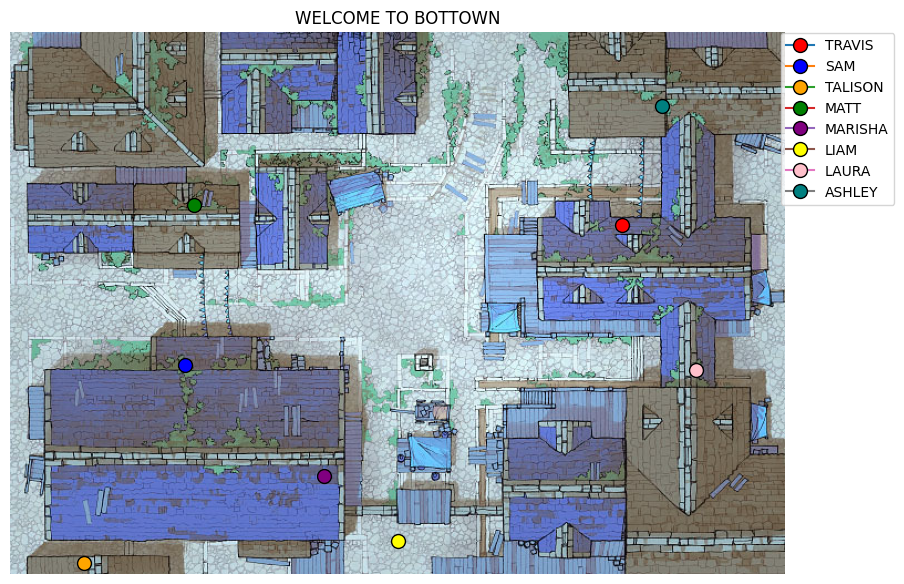

In [14]:

img = cv.imread("Bottown.jpg")
plt.figure(figsize=(10, 10), dpi=100) # dimesions 700,490                   
plt.imshow(img)
plt.axis('off')                                                    
plt.plot(Trav.x, Trav.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Trav.color,label=Trav.name)
plt.plot(Sam.x, Sam.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Sam.color,label=Sam.name)
plt.plot(Tal.x, Tal.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Tal.color,label=Tal.name)
plt.plot(Matt.x, Matt.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Matt.color,label=Matt.name)
plt.plot(Marisha.x, Marisha.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Marisha.color,label=Marisha.name)
plt.plot(Liam.x, Liam.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Liam.color,label=Liam.name)
plt.plot(Laura.x, Laura.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Laura.color,label=Laura.name)
plt.plot(Ashley.x, Ashley.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Ashley.color,label=Ashley.name)
plt.legend(bbox_to_anchor =(1.15, 1.01))
plt.title('WELCOME TO BOTTOWN')
plt.show()

# Now we bring it all together to make a bot town

No handles with labels found to put in legend.


LIAM LAURA
LIAM: I don't know.
LAURA: We could try.
LIAM: I'm going to use my bonus action to hide.
LAURA: Okay.
LIAM: So, I'm going to use my bonus action to dash and get to the top of the stairs.
LAURA: Okay.
17.49
LIAM LAURA
LIAM: I'll take the second one.
LAURA: Okay.
LIAM: Okay. 
LAURA: Yeah.  
LIAM: Oh, that's a good one. 
LAURA: That's a very good one, too.  
LIAM: I'm going to-- 
LAURA: I'm not going to do anything. 
LIAM: Okay.  
LAURA: And I'm going to cast-- 
LIAM: -- Fortune's Favor on myself. 
LAURA: I don't think I have it prepared.  
18.38
LIAM LAURA
LIAM: I'll go ahead and roll a d20 and add my wisdom modifier. 
LAURA: Oh, okay.  
LIAM: Yeah. 
LAURA: Okay.  
LIAM: So we'll say, for the purposes of this, the first one is a natural 20. 
LAURA: Okay.  
LIAM: I'm going to go ahead and roll a d20 and add my intelligence modifier. 
LAURA: Oh, that's good.  
LIAM: Yeah. 
LAURA: Okay.  
LIAM: I'm going to go ahead and cast Fortune's Favor on myself. 
LAURA: Okay.  
11.4
LIAM LA

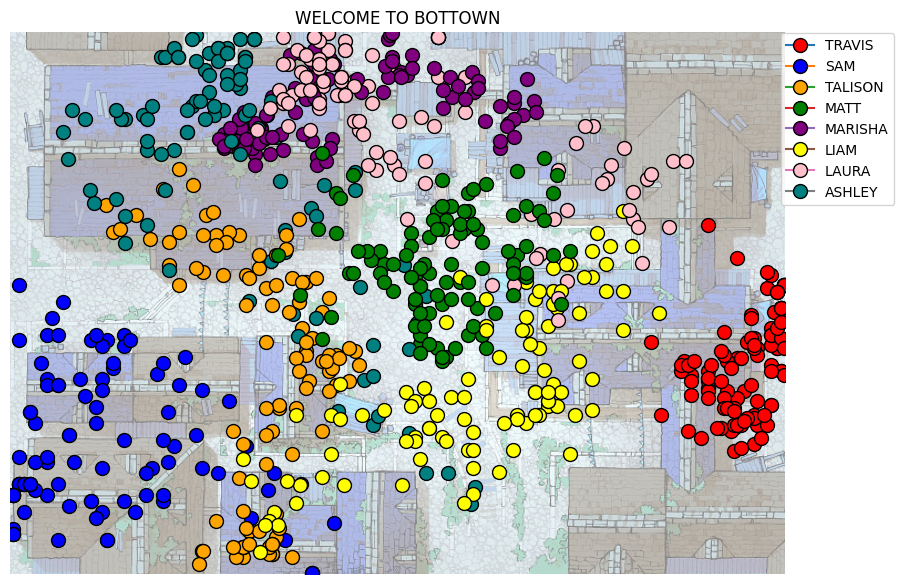

In [16]:
%matplotlib inline
import matplotlib.animation as animation 
import matplotlib.pyplot as plt 
import numpy as np 
  
   
# creating a blank window
# for the animation 
town=[Trav,Sam,Tal,Matt,Marisha,Liam,Laura,Ashley]
img = cv.imread("Bottown.jpg")
fig = plt.figure(figsize=(10, 10), dpi=100)
axis = plt.axes(xlim =(0, 700),
                ylim =(0, 490)) 
plt.imshow(img,alpha=.5)
plt.axis('off')  
plt.legend(bbox_to_anchor =(1.15, 1.01))
plt.title('WELCOME TO BOTTOWN')

plt.plot(Trav.x, Trav.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Trav.color,label=Trav.name)
plt.plot(Sam.x, Sam.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Sam.color,label=Sam.name)
plt.plot(Tal.x, Tal.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Tal.color,label=Tal.name)
plt.plot(Matt.x, Matt.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Matt.color,label=Matt.name)
plt.plot(Marisha.x, Marisha.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Marisha.color,label=Marisha.name)
plt.plot(Liam.x, Liam.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Liam.color,label=Liam.name)
plt.plot(Laura.x, Laura.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Laura.color,label=Laura.name)
plt.plot(Ashley.x, Ashley.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=Ashley.color,label=Ashley.name)
plt.legend(bbox_to_anchor =(1.15, 1.01))
# animation function 

convos=[]
def animate(i):
    # t is a parameter which varies
    # with the frame number
    townfolk,c=move_around(town)
    if(len(c)>0):
      convos.append(c)
    for k in town:
      axis.plot(k.x, k.y, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=k.color,label=k.name)
   
 
# calling the animation function     
anim = animation.FuncAnimation(fig,animate, frames=100)
from IPython.display import HTML
HTML(anim.to_html5_video())

In [54]:
k=7

print(f"{convos[k][0][0]} with {convos[k][0][1]}")
print('######################')
for i in convos[k][0][2]:
  print(f"{i[0]}:{i[1]}")

MARISHA with LAURA
######################
MARISHA: You can't get it back.  
LAURA: I can't, but I can try. 
MARISHA: You can't? 
LAURA: You can. 
MARISHA: I can. I can, yeah.  
LAURA: I can't? 
MARISHA: I can. 
LAURA: You can.
MARISHA: All right.
LAURA: So I'm going to cast Pass Without a Trace on us.
MARISHA: Okay.
LAURA: So you're going to do a straight line?
MARISHA: Yeah, I'm going to make a straight roll.
LAURA: Okay.
MARISHA: I'm going to take my staff and I'm just going to cast Control Water.
LAURA: Okay.
